# QBUS6830 Tutorial Lab 10: GARCH and Asymetric Models (ctd)
## Data
In this lab session we will use daily data on BHP returns, from Jan, 2000 to July, 2021. The data can be found in the files `bhp_yf_2000_2021.csv`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
import yfinance as yf
import os
from scipy.stats import kurtosis
from statsmodels.tsa.arima.model import ARIMA
from tqdm.notebook import tqdm
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from arch import univariate

In [2]:
# Download data automatically if file not present
name_bhp = 'bhp_yf_2000_2021.csv'

# BHP
if not os.path.isfile(name_bhp):
    data_bhp = yf.download("BHP.AX", start='2000-01-01', end='2021-07-20')
    data_bhp.to_csv(name_bhp)

In [3]:
data = pd.read_csv(name_bhp, index_col='Date', parse_dates=True, dayfirst=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,8.317775,8.317775,8.317775,8.317775,3.761003,0
2000-01-04,8.317359,8.620943,8.317359,8.608466,3.892442,9525499
2000-01-05,8.404691,8.462913,8.300724,8.408018,3.801807,8727404
2000-01-06,8.425485,8.566880,8.425485,8.462913,3.826628,7274950
2000-01-07,8.487449,8.941161,8.483706,8.880860,4.015611,15832421


#### (a) Choose an AR-GARCH model with AR lags 0 or 1, GARCH lags p,q in [1,...,5] and distribution either Gaussian or Student-t, all chosen by AIC/SIC.

In [4]:
p = data['Adj Close']
r = 100 * np.log(p).diff().dropna()

In [5]:
# constant mean GARCH(p,q)-N
aic = np.empty((5,5))
bic = np.empty((5,5))
for i in range(5):
    for j in range(5):
        arch = arch_model(r, mean='Constant', vol='GARCH', p=(i+1), q=(j+1), dist='normal')
        fit = arch.fit( disp= 'off' )
        aic[i,j] = fit.aic
        bic[i,j] = fit.bic
    
    
# AR(1)-GARCH(p,q)-N
aic_ar = np.empty((5,5))
bic_ar = np.empty((5,5))
for i in range(5):
    for j in range(5):
        arch = arch_model(r, mean='AR', lags=1, vol='GARCH', p=(i+1), q=(j+1), dist='normal')
        fit = arch.fit( disp= 'off' )
        aic_ar[i,j] = fit.aic
        bic_ar[i,j] = fit.bic
        

# constant mean GARCH(p,q)-t
aic_t = np.empty((5,5))
bic_t = np.empty((5,5))
for i in range(5):
    for j in range(5):
        arch = arch_model(r, mean='Constant', vol='GARCH', p=(i+1), q=(j+1), dist='StudentsT')
        fit = arch.fit( disp= 'off' )
        aic_t[i,j] = fit.aic
        bic_t[i,j] = fit.bic
        
        
# AR(1)-GARCH(p,q)-t
aic_at = np.empty((5,5))
bic_at = np.empty((5,5))
for i in range(5):
    for j in range(5):
        arch = arch_model(r, mean='AR', lags = 1, vol='GARCH', p=(i+1), q=(j+1), dist='StudentsT')
        fit = arch.fit( disp= 'off' )
        aic_at[i,j] = fit.aic
        bic_at[i,j] = fit.bic

In [6]:
# AIC: constant mean, normal error  # order 1,2 favoured
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_aic_n = pd.DataFrame(aic.round(1), index=idx, columns=col)
tbl_aic_n

,q=1,q=2,q=3,q=4,q=5
p=1,21265.2,21263.6,21265.6,21267.6,21269.5
p=2,21267.2,21265.6,21267.4,21269.4,21270.7
p=3,21269.2,21267.3,21267.0,21268.6,21269.6
p=4,21271.2,21269.3,21269.0,21270.6,21271.2
p=5,21273.2,21271.3,21271.0,21272.6,21272.1


In [7]:
p_min = tbl_aic_n.min(axis=1).idxmin()
q_min = tbl_aic_n.idxmin(axis=1)[p_min]
aic_min = tbl_aic_n.min().min()
print(p_min)
print(q_min)
print(aic_min)

p=1
q=2
21263.6


In [8]:
# AIC: constant mean, t error    # order 1,1 favoured
tbl_aic_t = pd.DataFrame(aic_t.round(1), index=idx, columns=col)
tbl_aic_t

,q=1,q=2,q=3,q=4,q=5
p=1,21184.3,21185.0,21187.0,21189.0,21191.0
p=2,21186.3,21186.4,21188.4,21190.4,21192.4
p=3,21188.1,21187.3,21188.0,21190.0,21191.5
p=4,21190.1,21189.3,21190.0,21192.0,21193.4
p=5,21192.1,21191.3,21192.0,21194.0,21194.3


In [9]:
p_min = tbl_aic_t.min(axis=1).idxmin()
q_min = tbl_aic_t.idxmin(axis=1)[p_min]
aic_min = tbl_aic_t.min().min()
print(p_min)
print(q_min)
print(aic_min)

p=1
q=1
21184.3


In [10]:
# AIC: AR(1) mean, t error  # order 1,1 favoured
tbl_aic_at = pd.DataFrame(aic_at.round(1), index=idx, columns=col)
tbl_aic_at

,q=1,q=2,q=3,q=4,q=5
p=1,21178.9,21179.8,21181.8,21183.8,21185.8
p=2,21180.9,21181.2,21183.2,21185.2,21187.2
p=3,21182.7,21182.0,21182.7,21184.7,21186.2
p=4,21184.7,21184.0,21184.7,21186.7,21188.2
p=5,21186.7,21186.0,21186.7,21188.7,21188.8


In [11]:
p_min = tbl_aic_at.min(axis=1).idxmin()
q_min = tbl_aic_at.idxmin(axis=1)[p_min]
aic_min = tbl_aic_at.min().min()
print(p_min)
print(q_min)
print(aic_min)

p=1
q=1
21178.9


In [12]:
# AIC: AR(1) mean, N error   # order 1,2 favoured
tbl_aic_a = pd.DataFrame(aic_ar.round(1), index=idx, columns=col)
tbl_aic_a

,q=1,q=2,q=3,q=4,q=5
p=1,21261.2,21259.7,21261.7,21263.7,21265.6
p=2,21263.2,21261.7,21263.5,21265.5,21266.8
p=3,21265.2,21263.4,21263.1,21264.7,21265.7
p=4,21267.2,21265.4,21265.1,21266.7,21267.2
p=5,21269.2,21267.4,21267.1,21268.7,21268.0


In [13]:
p_min = tbl_aic_a.min(axis=1).idxmin()
q_min = tbl_aic_a.idxmin(axis=1)[p_min]
aic_min = tbl_aic_a.min().min()
print(p_min)
print(q_min)
print(aic_min)

p=1
q=2
21259.7


In [14]:
# SIC: constant mean, normal error  # order 1,1 favoured
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_sic_n = pd.DataFrame(bic.round(1), index=idx, columns=col)
tbl_sic_n

,q=1,q=2,q=3,q=4,q=5
p=1,21291.6,21296.6,21305.2,21313.8,21322.3
p=2,21300.2,21305.2,21313.6,21322.2,21330.2
p=3,21308.8,21313.5,21319.8,21328.1,21335.7
p=4,21317.4,21322.1,21328.4,21336.7,21343.9
p=5,21326.0,21330.7,21337.0,21345.3,21351.4


In [15]:
p_min = tbl_sic_n.min(axis=1).idxmin()
q_min = tbl_sic_n.idxmin(axis=1)[p_min]
sic_min = tbl_sic_n.min().min()
print(p_min)
print(q_min)
print(sic_min)

p=1
q=1
21291.6


In [16]:
# SIC: AR(1) mean, normal error  # order 1,1 favoured
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_sic_an = pd.DataFrame(bic_ar.round(1), index=idx, columns=col)
tbl_sic_an

,q=1,q=2,q=3,q=4,q=5
p=1,21294.2,21299.3,21307.9,21316.5,21325.0
p=2,21302.8,21307.9,21316.3,21324.9,21332.8
p=3,21311.4,21316.2,21322.5,21330.7,21338.3
p=4,21320.0,21324.8,21331.1,21339.4,21346.5
p=5,21328.6,21333.4,21339.7,21348.0,21353.9


In [17]:
p_min = tbl_sic_an.min(axis=1).idxmin()
q_min = tbl_sic_an.idxmin(axis=1)[p_min]
sic_min = tbl_sic_an.min().min()
print(p_min)
print(q_min)
print(sic_min)

p=1
q=1
21294.2


In [18]:
# SIC: constant mean, t error  # order 1,1 favoured
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_sic_t = pd.DataFrame(bic_t.round(1), index=idx, columns=col)
tbl_sic_t

,q=1,q=2,q=3,q=4,q=5
p=1,21217.3,21224.6,21233.2,21241.8,21250.4
p=2,21225.9,21232.6,21241.2,21249.8,21258.4
p=3,21234.4,21240.1,21247.4,21256.0,21264.1
p=4,21243.0,21248.7,21256.0,21264.6,21272.7
p=5,21251.6,21257.3,21264.6,21273.2,21280.1


In [19]:
p_min = tbl_sic_t.min(axis=1).idxmin()
q_min = tbl_sic_t.idxmin(axis=1)[p_min]
sic_min = tbl_sic_t.min().min()
print(p_min)
print(q_min)
print(sic_min)

p=1
q=1
21217.3


In [20]:
# SIC: AR(1) mean, t error  # order 1,1 favoured
i = np.arange(1, 6)
idx = pd.Series(i).apply(lambda i: 'p=' + str(i))
col = pd.Series(i).apply(lambda i: 'q=' + str(i))
tbl_sic_at = pd.DataFrame(bic_at.round(1), index=idx, columns=col)
tbl_sic_at

,q=1,q=2,q=3,q=4,q=5
p=1,21218.6,21226.0,21234.6,21243.2,21251.8
p=2,21227.2,21234.0,21242.6,21251.2,21259.8
p=3,21235.6,21241.5,21248.7,21257.3,21265.4
p=4,21244.2,21250.1,21257.3,21265.9,21274.0
p=5,21252.8,21258.7,21265.9,21274.5,21281.3


In [21]:
p_min = tbl_sic_at.min(axis=1).idxmin()
q_min = tbl_sic_at.idxmin(axis=1)[p_min]
sic_min = tbl_sic_at.min().min()
print(p_min)
print(q_min)
print(sic_min)

p=1
q=1
21218.6


### Answer guide
When using AIC, either the GARCH order 1,1 or 1,2 are favoured; overall AIC favours the AR(1)-GARCH(1,1)-t model.  
When using SIC, only the GARCH order 1,1 is favoured in all cases; overall AIC favours the constant mean GARCH(1,1)-t model.

It is nice when SIC and AIC nearly agree: here they agree on choosing the GARCH(1,1)-t model. We already fit the AR(1) version of this model in week 9 tutorial. I choose the constant mean model to fit now.

#### (b) Fit the GARCH model as chosen by AIC or SIC to the percentage log returns. What is the fitted model? Are all chosen GARCH lags significant?

In [22]:
garch11_t = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='StudentsT')
garch11_t_fit = garch11_t.fit( disp="off" )  #last_obs='2017-10-17'
print(garch11_t_fit.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -10587.2
Distribution:      Standardized Student's t   AIC:                           21184.3
Method:                  Maximum Likelihood   BIC:                           21217.3
                                              No. Observations:                 5450
Date:                      Fri, Oct 22 2021   Df Residuals:                     5449
Time:                              11:57:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### Answer guide
The fitted model is $r_t = 0.075 + a_t$ (mean equation), $\sigma_t^2 = 0.031 + 0.055 a_{t-1}^2 + 0.94 \sigma_{t-1}^2$ (volatility equation)

Both GARCH lag parameters ($\alpha_1, \beta_1$) are highly significant, and at a 5% level, with both p-values $ << 0.05$ and $\approx 0$.

#### (c) Assess the fit of the GARCH model using ACF plots, Ljung-Box and ARCH tests and a histogram/qqplot together with the Jarque-Bera test.

In [23]:
## Statistical diagnostics for G/ARCH models.
def assess_fit_stats( e, df ):
    ## Ljung-Box tests on standardised (transformed if t error) residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    print( "Ljung-Box Q-statistic on standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## Ljung-Box tests on squared standardised (transformed if t error) residuals
    print( "Ljung-Box Q-statistic on squared standardised residuals:" )
    for p in [ df + 5, df + 10 ]:
        Qstat, pValue = acorr_ljungbox( e*e, lags = [p], model_df = df, return_df = False )
        print('maxlag: {0:d}. Q-stat: {1:f}. P-value: {2:f}'.format( p, Qstat[0], pValue[0] ) )
    print()

    ## ARCH test on mean-corrected returns
    ## The null hypothesis is no ARCH errors.
    from statsmodels.stats.diagnostic import het_arch
    print( "Engle ARCH statistic:")
    for p in [ 5, 10 ]:
        Teststat, pValue, _, _ = het_arch( resid=e, nlags=p )
        print('maxlag: {0:d}. ARCH test statistic: {1:f}. P-value: {2:f}'.format( p, Teststat, pValue) )
    print()

    ## Jarque-Bera tests (transformed errors if t error)
    from statsmodels.stats.stattools import jarque_bera
    print( 'Skewness: {0:f}'.format( stats.skew( e ) ) )
    print( 'Kurtosis: {0:f}'.format( stats.kurtosis( e ) + 3 ) )
    JB_test_stat, JB_pvalue, _, _ = jarque_bera( e )
    print( 'JB test statistic: {0:f}. P-value {1:f}'.format( JB_test_stat, JB_pvalue ) )
    print()


In [24]:
## Plot diagnostics for G/ARCH models.
def assess_fit_plots( e, name ):
    #Plot standardised residuals.
    plt.plot( e )
    plt.title( '{0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of standardised residuals.
    sm.graphics.tsa.plot_acf( e, lags=20 )
    plt.title( 'ACF of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the histogram of standardised residuals.
    plt.hist( e, bins = 25 )
    plt.title( 'Histogram of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## QQ plot of standardised residuals against the normal distribution.
    sm.qqplot( e, line = 'r')
    plt.title( 'QQ Plot of {0} Standardised Residuals'.format( name ) )
    plt.show()

    ## Plot the ACF of squared standardised residuals.
    sm.graphics.tsa.plot_acf( e*e, lags=20 )
    plt.title( 'ACF of {0} Squared Standardised Residuals'.format( name ) )
    plt.show()
    

In [25]:
dfg = garch11_t_fit.params['nu']

eg_t = garch11_t_fit.std_resid

ug = stats.t.cdf(np.sqrt(dfg / (dfg - 2)) * eg_t, dfg)
eg = stats.norm.ppf(ug)

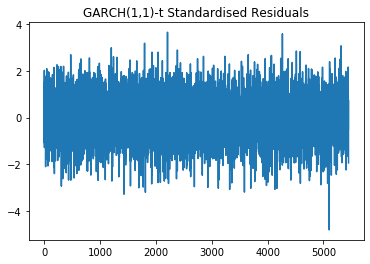

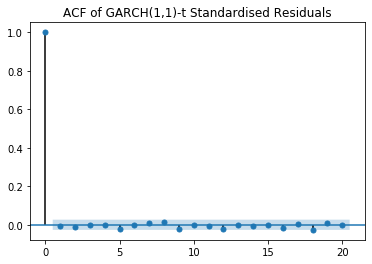

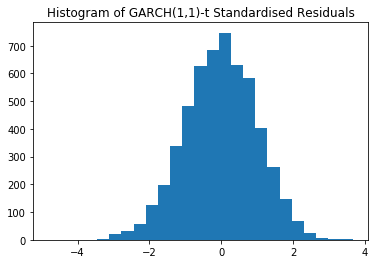

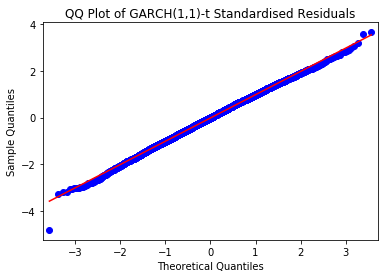

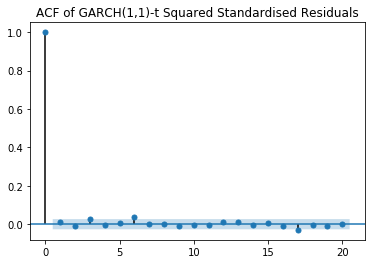

In [26]:
assess_fit_plots( eg, 'GARCH(1,1)-t' )

In [27]:
assess_fit_stats(eg, 3)    #   3 is the model dof, 2 for GARCH equation and 1 for Student-t dof.  

Ljung-Box Q-statistic on standardised residuals:
maxlag: 8. Q-stat: 5.432365. P-value: 0.365419
maxlag: 13. Q-stat: 10.742514. P-value: 0.377927

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 8. Q-stat: 13.033062. P-value: 0.023071
maxlag: 13. Q-stat: 14.962955. P-value: 0.133418

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 5.648063. P-value: 0.341983
maxlag: 10. ARCH test statistic: 13.899478. P-value: 0.177626

Skewness: -0.110840
Kurtosis: 3.014730
JB test statistic: 11.208575. P-value 0.003682



### Answer guide
The ACF of the transformed residuals from the GARCH-t model shows a general lack of autocorrelation in the residuals at all lags. This is confirmed by the Ljung-Box (LB) tests, using 8 and 13 lags, i.e. 5 and 10 degrees of freedom; i.e. 3 dof is from  the 2 GARCH(1,1) effects plus the dof from the Student-t. Both LB tests have p-val $>0.05$, indicating that no significant autocrrelation exists in the first 8 or 13 lags of the residuals. Thus, the constant mean equation fits the data well and cannot be rejected. 

The ACF of the squared transformed residuals shows a couple of moderate ARCH effects in the residuals, only at lags 3 and 6.  The Ljung-Box (LB) tests, using 8 and 13 lags, i.e. 5 and 10 degrees of freedom, disagree with each other here. The test using 8 lags has p-value $=0.023 <0.05$, indicating statistically significant ARCH effects remain in the first 8 lags of the transformed residuals from the GARCH-t model. However, the test using 13 lags has p-value $=0.133 > 0.05$, indicating no statistically significant ARCH effects remain in the first 13 lags of the transformed residuals from the GARCH-t model. Thus, it is unclear what the tests suggest about the volatility equation of the GARCH-t model. Engle's ARCH tests fails to reject the hypothesis of no ARCH effects in the residuals. It seems as though the GARCH equation is very nearly adequate for this data. 

Finally, the Histogram and QQ-plot for the transformed residuals show an apparent distribution close to normality or Gaussian, except for a single negative outlier in the QQ-plot. Whilst the sample skewness and kurtosis are very close to 0 and 3 respectively, again the JB test does not confirm this, with p-value $= 0.004 <0.05$, indicating that we can reject normality for the transformed residuals and hence reject the standardised Student-t which does not fit the conditional BH return distribution well. Again this result seems driven by the skewness of $-0.11$ being significantly below 0, which seems mostly affected by the single negative outlier apparent in the QQ-plot.  

Upon inspection, this large outlier occurs at the start of the covid outbreak in early 2020. Since this large negative return did actually occur and was experienced by investors in BHP, this data point is not a mistake and so cannot simply be deleted from our analysis validly. It is simply an unpredictable event that our model cannot explain or cater for, mianly in the error distribution specification. These sorts of large negative outliers make error distribiution specification very, very challenging and help motivate the choice of semi-parametric methods that avoid that choice; as we shall see in module 4 of this unit.  

#### (d) Using the GARCH parameter estimates, find the weights on the previous 20 lagged squared shocks in the GARCH equation for $\sigma_t^2$. How do these weights compare to the ARCH(13) model from lab tutorial 9?

In [28]:
# Re-fit ARCH(13) model
arch13 = arch_model(r, mean='Constant', vol='ARCH', dist='StudentsT', p=13)
arch13_fit = arch13.fit(disp="off")
arch13_fit.params[2:].values

array([ 0.07793455,  0.0504307 ,  0.08793152,  0.0465962 ,  0.07735239,
        0.07867587,  0.06496952,  0.05053849,  0.03357021,  0.04495648,
        0.0433371 ,  0.05300495,  0.05592401, 11.5097755 ])

In [29]:
print(arch13_fit.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -10615.3
Distribution:      Standardized Student's t   AIC:                           21262.6
Method:                  Maximum Likelihood   BIC:                           21368.3
                                              No. Observations:                 5450
Date:                      Fri, Oct 22 2021   Df Residuals:                     5449
Time:                              11:57:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [30]:
a1 = garch11_t_fit.params['alpha[1]']
b1 = garch11_t_fit.params['beta[1]']
w_garch = a1 * b1 ** np.arange(20)
w_arch13 = np.zeros(20)
w_arch13[:13] = arch13_fit.params[2:-1].values
l = np.arange(1, 21)

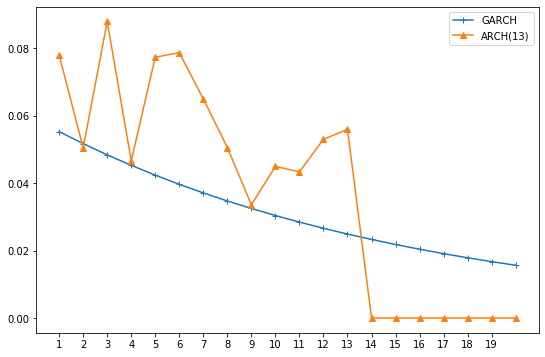

In [31]:
plt.figure(figsize=(9, 6))
plt.plot(l, w_garch, '-+', label='GARCH')
plt.plot(l, w_arch13, '-^', label='ARCH(13)')
plt.legend()
plt.xticks(np.arange(1, 20, 1), np.arange(1, 20, 1))
plt.show()

### Answer guide
Clearly the GARCH weights and the ARCH weights are only vaguely similar to each other. In fact, 12 of the 13 ARCH lag effect estimates are higher than the corresponding ones for the GARCH model; recall that in a GARCH model the weight on $a_{t-i}^2$ is given by $\alpha_1 \beta_1^{i-1}$ for $i=1,\ldots,t-1$. The GARCH weights are designed to smoothly decrease down to 0 at a rate determined by $\beta_1$, starting from $\alpha_1$; the ARCH weights cut-off after $p$ in a ARCH($p$) model. 

As we saw in Tutorial 9, in this case the GARCH weights seem to be more accurate, according to the tests for remaining ARCH effects in the residuals from those two models. 

#### (d) Add a GJR lag 1 term to the GARCH equation in the chosen model above. Fit the model.

In [32]:
gjr11_t = arch_model(r, mean='Constant', vol='GARCH', p=1, o=1, q=1, dist='StudentsT')
gjr11_t_fit = gjr11_t.fit( disp="off" )
print(gjr11_t_fit.summary())

dfgj = gjr11_t_fit.params['nu']
agj_t = gjr11_t_fit.resid
egj_t = gjr11_t_fit.std_resid
ugj = stats.t.cdf(np.sqrt(dfgj / (dfgj - 2)) * egj_t, dfgj)
egj = stats.norm.ppf(ugj)

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -10579.3
Distribution:      Standardized Student's t   AIC:                           21170.6
Method:                  Maximum Likelihood   BIC:                           21210.3
                                              No. Observations:                 5450
Date:                      Fri, Oct 22 2021   Df Residuals:                     5449
Time:                              11:57:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

### Answer guide
The fitted model is $r_t = 0.059 + a_t$ (mean equation), $\sigma_t^2 = 0.032 + (0.033 + 0.037 I_{t-1}) a_{t-1}^2 + 0.94 \sigma_{t-1}^2$ (volatility equation)

Both GARCH lag parameters ($\alpha_1, \beta_1$) are highly significant, and at a 5% level, with both p-values $ << 0.05$ and $\approx 0$. The asymmetry parameter $\gamma$ is also highly significant, and at a 5% level, with p-value $ << 0.05$. The data seems to support the leverage effect hypothesis, as we reject $\gamma=0$ in favour of $\gamma>0$ here, i.e. volatility increases more following same size negative shocks, compared to positive.

### Q1(c) Draw and discuss the two news impact curves from this model.

$$\frac{a_t}{\sigma_t}$$

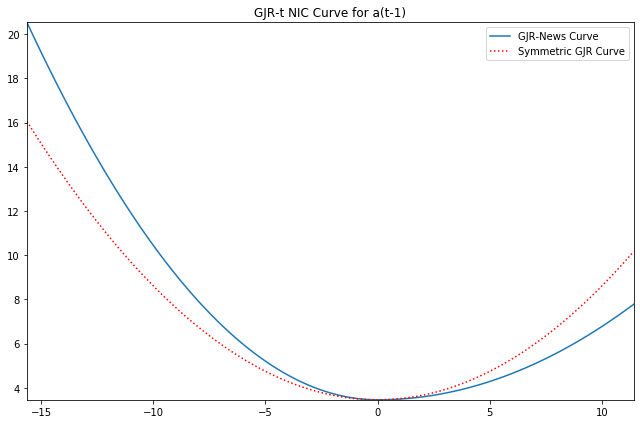

In [33]:
alpha0 = gjr11_t_fit.params['omega']
alpha1 = gjr11_t_fit.params['alpha[1]']
gamma = gjr11_t_fit.params['gamma[1]']
beta = gjr11_t_fit.params['beta[1]']

e = gjr11_t_fit.std_resid
a = e * gjr11_t_fit.conditional_volatility
sig2 = a.var()

x = np.linspace(a.min(), a.max(), num=100)
s2 = lambda x: alpha0 + (alpha1 + gamma * (x < 0)) * (x ** 2) + beta * sig2
s2_sym = lambda a: alpha0 + (alpha1 + gamma / 2) * (a ** 2) + beta * sig2

plt.figure(figsize=(9, 6))
plt.plot(x, s2(x), label='GJR-News Curve')
plt.plot(x, s2_sym(x), ':r', label='Symmetric GJR Curve')
plt.axis([x[0], x[-1], s2(0), max(s2(x[0]), s2(x[-1]), s2_sym(x[0]), s2_sym(x[-1]))])
plt.title('GJR-t NIC Curve for a(t-1)')
plt.tight_layout()
plt.legend()
plt.show()

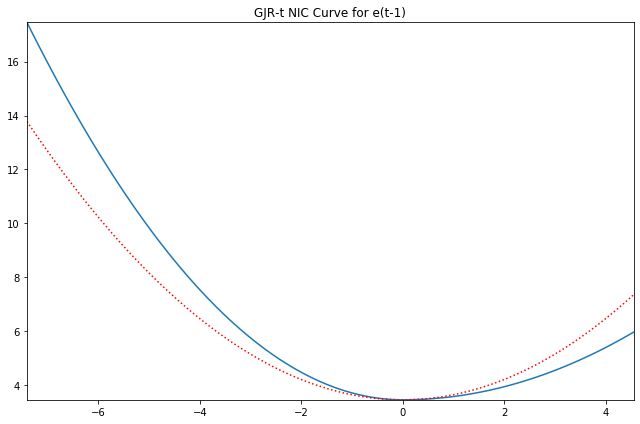

In [34]:
# Over e(t-1)
alpha0 = gjr11_t_fit.params['omega']
alpha1 = gjr11_t_fit.params['alpha[1]']
gamma = gjr11_t_fit.params['gamma[1]']
beta = gjr11_t_fit.params['beta[1]']

e = gjr11_t_fit.std_resid
a = e * gjr11_t_fit.conditional_volatility
sig2 = a.var()
sig = np.sqrt(sig2)

x = np.linspace(e.min(), e.max(), num=100)
s2 = lambda e: alpha0 + (alpha1 + gamma * ((sig * e) < 0)) * ((sig * e) ** 2) + beta * sig2
s2_sym = lambda e: alpha0 + (alpha1 + gamma / 2) * ((sig * e) ** 2) + beta * sig2
plt.figure(figsize=(9, 6))
plt.plot(x, s2(x))
plt.plot(x, s2_sym(x), ':r')
plt.axis([x[0], x[-1], s2(0), max(s2(x[0]), s2(x[-1]), s2_sym(x[0]), s2_sym(x[-1]))])
plt.title('GJR-t NIC Curve for e(t-1)')
plt.tight_layout()
plt.show()

### Answer guide
The level of asymmetry is clearly illustrated in the two NICs, with volatility following negative return shocks being higher than that following positive return shocks of the same size. This is illustrated by the blue line being above the symmetric line for negative shocks and below it for positive shocks. 

There is not much difference between the 2 plots visually; qualitatively they tell the same story. 

#### (e) Assess the level of volatility asymmetry in the BHP returns.

In [35]:
print(gjr11_t_fit.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -10579.3
Distribution:      Standardized Student's t   AIC:                           21170.6
Method:                  Maximum Likelihood   BIC:                           21210.3
                                              No. Observations:                 5450
Date:                      Fri, Oct 22 2021   Df Residuals:                     5449
Time:                              11:57:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

$$\sigma_t^2 = \alpha_0 + (\alpha_1 + \gamma_1 I_{t-1})\alpha_{t-1}^2 + \beta_1\sigma_{t-1}^2$$

$$\sigma_t^2 = 0.032 + (0.0332 + 0.0367I_{t-1})\alpha_{t-1}^2 + 0.9381\sigma_{t-1}^2$$

In [36]:
a0GJt = gjr11_t_fit.params['omega']

a1GJt = gjr11_t_fit.params['alpha[1]']
g1GJt = gjr11_t_fit.params['gamma[1]']
b1GJt = gjr11_t_fit.params['beta[1]']

In [37]:
gjr11_t_fit.conditional_volatility

Date
2000-01-04    2.287157
2000-01-05    2.306055
2000-01-06    2.329963
2000-01-07    2.266310
2000-01-10    2.367168
                ...   
2021-07-13    1.436455
2021-07-14    1.416577
2021-07-15    1.386087
2021-07-16    1.367896
2021-07-19    1.341337
Name: cond_vol, Length: 5450, dtype: float64

In [38]:
# conditional_volatility = σ_{t-1}
std = gjr11_t_fit.conditional_volatility.values[-1]
sg = std ** 2

In [39]:
#compare predicted conditional standard deviation values following positive and negative shocks of size 2
a = -2;
sigtm2 = alpha0 + ((alpha1 + gamma) * a**2) + (beta * sg)

a = 2
sigta2 = alpha0 + (alpha1 * a**2) + (beta * sg)
print('\npredicted conditional variance values following positive and negative shocks of size 2 and ratio: {}, {}, {}'.format(round(sigtm2,4), round(sigta2,4), round(sigtm2/sigta2,4)))

print(a1GJt, a1GJt+g1GJt)
print(a1GJt+b1GJt, a1GJt+g1GJt+b1GJt)


predicted conditional variance values following positive and negative shocks of size 2 and ratio: 1.9997, 1.8527, 1.0793
0.033232047205535915 0.0699782210866241
0.9712957389656216 1.0080419128467097


In [40]:
sigtm2 / sigta2

1.0793348849682687

### Answer guide
We can measure the amount of volatility asymmetry in several ways. First, the conventional measure is to take the ratio of estimated volatility at $a_{t-1} = -2$ and compare it to that for $a_{t-1}=2$. Doing so, at the average variance level for $\sigma_{t-1}^2$, yields a ratio of 1.041, i.e. variance rises by 4.1% more when yesterday's return shock is $-2$%, compared to when it is $+2$%. 

The ARCH effect, the effect of $a_{t-1}^2$ of variance, is 0.033 when $a_{t-1}>0$ and $0.07$ when $a_{t-1}<0$; i.e the effect of yesterday's squared return shock more than doubles when yesterday's return is negative. 

Volatility persistence is 0.97 when $a_{t-1}>0$ but is explosive at 1.01 > 1 when $a_{t-1}<0$; i.e. the volatility process is explosive, non-stationary and has no long-run average volatility and no mean reversion following negative return shocks. 

In summary, even though at the average level of variance, the 4.1% increase for negative over positive 2% shocks seems small, the volatility process is quite different follwoing negative shocks, being estimated as non-stationary in that case, compared to positive return shocks. 

### (f) Assess the fit of the GJR-GARCH model

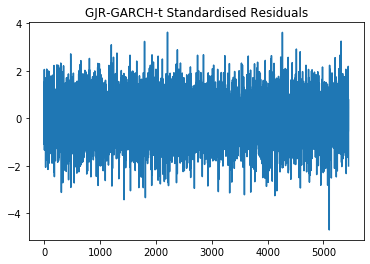

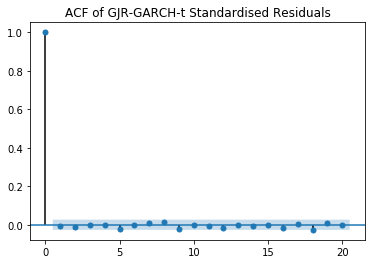

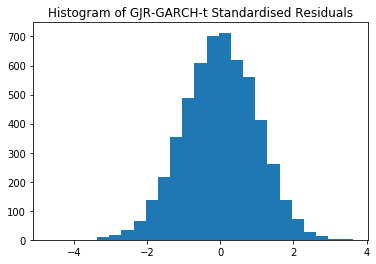

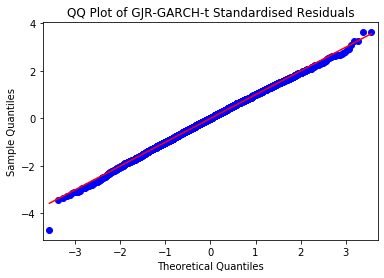

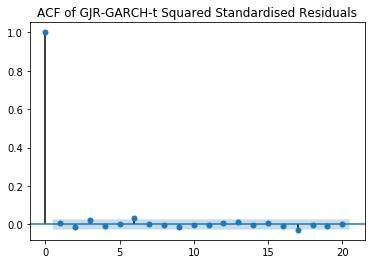

In [41]:
assess_fit_plots( egj, 'GJR-GARCH-t' )

In [42]:
assess_fit_stats( egj, 4 )   

Ljung-Box Q-statistic on standardised residuals:
maxlag: 9. Q-stat: 8.312463. P-value: 0.139835
maxlag: 14. Q-stat: 10.673773. P-value: 0.383492

Ljung-Box Q-statistic on squared standardised residuals:
maxlag: 9. Q-stat: 11.083557. P-value: 0.049748
maxlag: 14. Q-stat: 12.379689. P-value: 0.260449

Engle ARCH statistic:
maxlag: 5. ARCH test statistic: 4.741248. P-value: 0.448267
maxlag: 10. ARCH test statistic: 11.217800. P-value: 0.340803

Skewness: -0.113505
Kurtosis: 3.017239
JB test statistic: 11.769965. P-value 0.002781



### Answer guide
The ACF of the transformed residuals from the GJR-GARCH-t model shows a general lack of autocorrelation in the residuals at all lags. This is confirmed by the Ljung-Box (LB) tests, using 9 and 14 lags, i.e. 5 and 10 degrees of freedom; i.e. 4 dof is from  the 2 GARCH(1,1) effects plus GJR(1) effect, plus the dof from the Student-t. Both LB tests have p-val $>0.05$, indicating that no significant autocrrelation exists in the first 9 or 14 lags of the residuals. Thus, the constant mean equation fits the data well and cannot be rejected. 

The ACF of the squared transformed residuals shows a general lack of ARCH effects in the residuals, no clear significant lags.  The Ljung-Box (LB) tests, using 9 and 14 lags, i.e. 5 and 10 degrees of freedom, somewhat disagree with each other here. The test using 9 lags has p-value $=0.0498 <0.05$, indicating very weak statistically significant ARCH effects remain in the first 9 lags of the transformed residuals from the GJR-GARCH-t model; this is a very marginal result. However, the test using 14 lags has p-value $=0.261 > 0.05$, indicating no statistically significant ARCH effects remain in the first 14 lags of the transformed residuals from the GJR-GARCH-t model. Engle's ARCH tests fails to reject the hypothesis of no ARCH effects in the residuals. Thus, the tests suggest that the volatility equation of the GJR-GARCH-t model is very close to, and mostly, adequate for this data; it is the best so far re these tests. 

Finally, the Histogram and QQ-plot for the transformed residuals show an apparent distribution close to normality or Gaussian, except for a single negative outlier in the QQ-plot. Whilst the sample skewness and kurtosis are very close to 0 and 3 respectively, again the JB test does not confirm this, with p-value $= 0.003 <0.05$, indicating that we can reject normality for the transformed residuals and hence reject the standardised Student-t which does not fit the conditional BH return distribution well. Again this result seems driven by the skewness of $-0.11$ being significantly below 0, which seems mostly affected by the single negative outlier apparent in the QQ-plot.  

This is the same large outlier that occurs at the start of the covid outbreak in early 2020. Since this large negative return did actually occur and was experienced by investors in BHP, this data point is not a mistake and so cannot simply be deleted from our analysis validly. 

### (f) Compare the estimated volatility series of the GJR-GARCH to the GARCH model

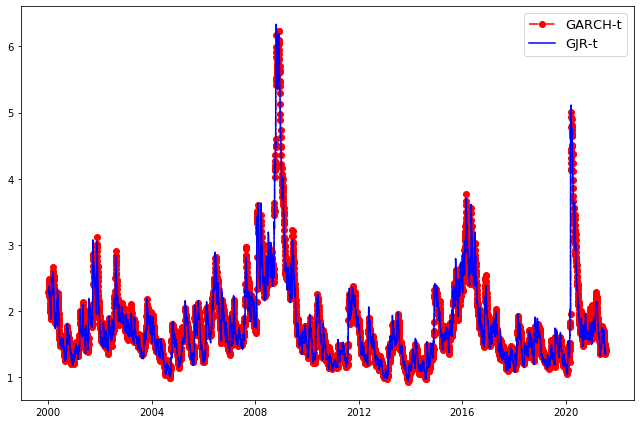

In [43]:
s_gjr = gjr11_t_fit.conditional_volatility
s_g = garch11_t_fit.conditional_volatility
plt.figure(figsize=(9, 6))
plt.plot(s_g, 'ro-.', label='GARCH-t')
plt.plot(s_gjr, 'b', label='GJR-t')
plt.legend(fontsize=13)
plt.tight_layout()
plt.show()

### Answer guide
Surprisingly there seems to be few clear differences in the symmetric GARCH and asymmetric GJR estimated volatility series. We would expect to see the red circles higher than the blue line following negative shocks, but this behavior is not clear (to me).

#### (g) Fit two constant mean EGARCH(1,0) models, one with Gaussian and one with Student-t errors. What are the fitted models? Draw the NIC from these two models.

In [44]:
egarch = arch_model(r, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='Normal')
egarch_fit = egarch.fit( disp="off" )
print(egarch_fit.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -10617.7
Distribution:                  Normal   AIC:                           21245.4
Method:            Maximum Likelihood   BIC:                           21278.5
                                        No. Observations:                 5450
Date:                Fri, Oct 22 2021   Df Residuals:                     5449
Time:                        11:57:45   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0472  2.120e-02      2.226  2.602e-02 [5.

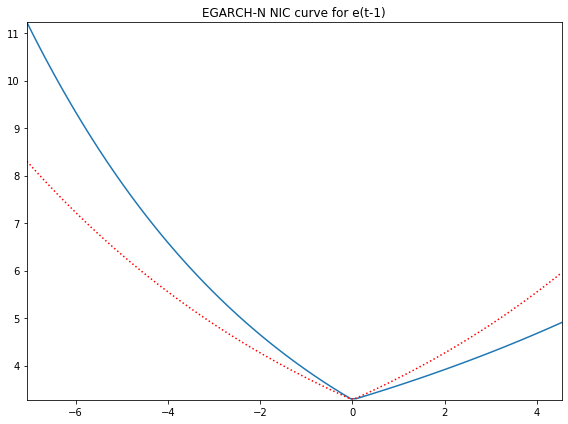

In [45]:
e_egarch = egarch_fit.std_resid
s_egarch = egarch_fit.conditional_volatility

alpha0 = egarch_fit.params['omega']
alpha1 = egarch_fit.params['alpha[1]']
gamma = egarch_fit.params['gamma[1]']
beta = egarch_fit.params['beta[1]']
e = egarch_fit.std_resid
a = e * egarch_fit.conditional_volatility
sig2 = a.var()
x = np.linspace(e.min(), e.max(), num=100)
s2 = lambda e: np.exp(alpha0 + alpha1 * (np.abs(e) - np.sqrt(2 / np.pi)) +
                      beta * np.log(sig2) + gamma * e)
s2_sym = lambda e: np.exp(alpha0 + alpha1 * (np.abs(e) - np.sqrt(2 / np.pi)) +
                          beta * np.log(sig2))
plt.figure(figsize=(8, 6))
plt.plot(x, s2(x))
plt.plot(x, s2_sym(x), ':r')
plt.axis([x[0], x[-1], s2(0), max(s2(x[0]), s2(x[-1]), s2_sym(x[0]), s2_sym(x[-1]))])
plt.title('EGARCH-N NIC curve for e(t-1)')
plt.tight_layout()
plt.show()

In [46]:
# EGARCH-t
egarch_t = arch_model(r, mean='Constant', vol='EGARCH', p=1, o=1, q=1, dist='StudentsT')
egarch_t_fit = egarch_t.fit( disp="off" )
print(egarch_t_fit.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -10578.3
Distribution:      Standardized Student's t   AIC:                           21168.7
Method:                  Maximum Likelihood   BIC:                           21208.3
                                              No. Observations:                 5450
Date:                      Fri, Oct 22 2021   Df Residuals:                     5449
Time:                              11:57:46   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

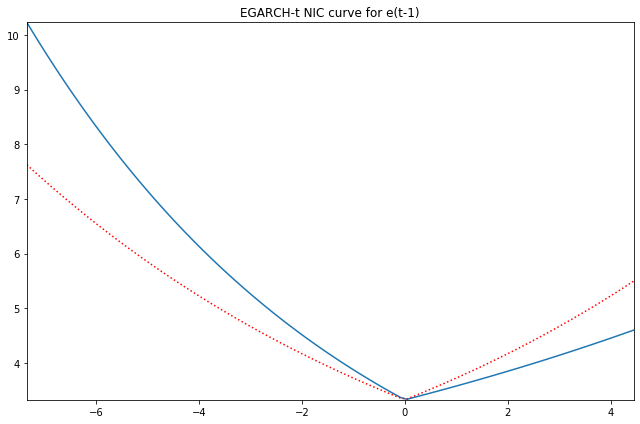

In [47]:
e_egarch_t = egarch_t_fit.std_resid
s_egarch_t = egarch_t_fit.conditional_volatility
alpha0 = egarch_t_fit.params['omega']
alpha1 = egarch_t_fit.params['alpha[1]']
gamma = egarch_t_fit.params['gamma[1]']
beta = egarch_t_fit.params['beta[1]']
e = egarch_t_fit.std_resid
a = e * egarch_t_fit.conditional_volatility
sig2 = a.var()
x = np.linspace(e.min(), e.max(), num=100)
s2 = lambda e: np.exp(alpha0 + alpha1 * (np.abs(e) - np.sqrt(2 / np.pi)) +
                      beta * np.log(sig2) + gamma * e)
s2_sym = lambda e: np.exp(alpha0 + alpha1 * (np.abs(e) - np.sqrt(2 / np.pi)) +
                          beta * np.log(sig2))
plt.figure(figsize=(9, 6))
plt.plot(x, s2(x))
plt.plot(x, s2_sym(x), ':r')
plt.axis([x[0], x[-1], s2(0), max(s2(x[0]), s2(x[-1]), s2_sym(x[0]), s2_sym(x[-1]))])
plt.title('EGARCH-t NIC curve for e(t-1)')
plt.tight_layout()
plt.show()

### Answer guide
The level of asymmetry is clearly illustrated in the two NICs, with volatility following negative return shocks higher than that following positive return shocks of the same size. This is illustrated by the blue line being above the symmetric line for negative shocks and below it for positive shocks. 

There is not much difference between the 2 plots visually; qualitatively they tell the same story. 

#### (h) Assess the level of volatility asymmetry in the BHP returns from the EGARCH models. Do they agree: (i) with the GJR model; (b) with each other?

In [48]:
# level of asymmetry

gm_n = egarch_fit.params['gamma[1]']
gm_t = egarch_t_fit.params['gamma[1]']

print((-4 * gm_n), np.exp(-4 * gm_n))
print((-4 * gm_t), np.exp(-4 * gm_t))

0.1710926233715401 1.1866006508848492
0.15995359297388506 1.173456413105798


### Answer guide
The level of asymmetry, in response to $\varepsilon_{t-1}$ being -2 or 2 standard deviations, in an EGARCH is measured by $\exp{-2c \gamma}$. In both cases above, the estimate is close to $\approx 18$%. Thus, variance of BHP returns is estimated to increase by 18% following return shocks of -2 standard deviations, compared to those of $+2$ standard deviations. 

This is much higher than the 4% increase esimated for the GJR model.

#### (i) Compare the volatility estimates from all the models above.

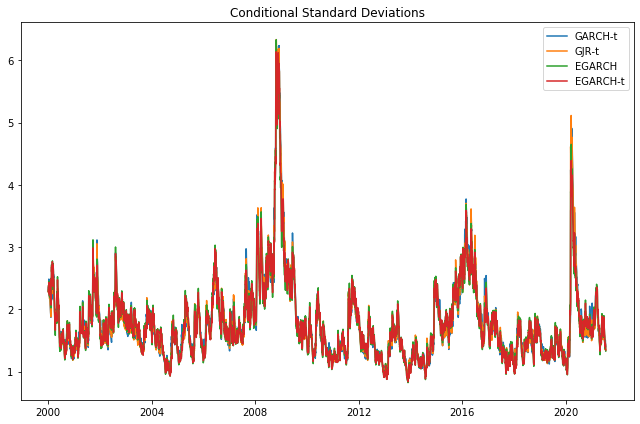

In [49]:
s_egarch = egarch_fit.conditional_volatility
s_egarch_t = egarch_t_fit.conditional_volatility
plt.figure(figsize=(9, 6))
plt.plot(s_g, label='GARCH-t')
plt.plot(s_gjr, label='GJR-t')
plt.plot(s_egarch, label='EGARCH')
plt.plot(s_egarch_t, label='EGARCH-t')
plt.title('Conditional Standard Deviations')
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

### Answer guide
Once again, surprisingly there seems to be few clear differences in the symmetric GARCH and asymmetric GJR or EGARCH estimated volatility series. We would expect to see the GJR and EGARCH volatility estimates higher than the GARCH ones following negative shocks, but this behavior is not clear (to me); mostly the 4 series seem quite close together on almost all days.

#### (h) Find 1-step ahead predictions of VaR and ES at $\alpha$ = 0.025, 0.01 for BHP on 20/07/2021 under all the models above. Which risk level forecasts do you think are more accurate and/or believable?

In [50]:
r

Date
2000-01-04    3.435129
2000-01-05   -2.356032
2000-01-06    0.650759
2000-01-07    4.820532
2000-01-10    0.769651
                ...   
2021-07-13   -0.687956
2021-07-14    0.511505
2021-07-15    1.112315
2021-07-16    0.657646
2021-07-19   -2.676728
Name: Adj Close, Length: 5450, dtype: float64

In [51]:
# 1 step ahead VaR, ES 

# Fit GARCH-N
garch_n = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
garch_n_fit = garch_n.fit( disp= 'off' )

SFgt = np.sqrt( garch11_t_fit.forecast( horizon = 1 ).variance.values[-1, 0] ) 
SFegn = np.sqrt( egarch_fit.forecast(horizon = 1).variance.values[-1, 0 ] ) 
SFgn = np.sqrt( garch_n_fit.forecast(horizon = 1).variance.values[-1, 0 ] ) 
SFat = np.sqrt( arch13_fit.forecast(horizon = 1).variance.values[-1, 0 ] ) 
SFegt = np.sqrt( egarch_t_fit.forecast(horizon = 1).variance.values[-1, 0 ] ) 
SFgjt = np.sqrt( gjr11_t_fit.forecast( horizon = 1 ).variance.values[-1, 0] ) 
print(SFgn, SFegn, SFat, SFgt, SFgjt, SFegt)

1.5238371848175472 1.515469995549275 1.6005443888427535 1.5106673096778258 1.4978507773069343 1.5109253449294753


/Users/jameschok/anaconda3/lib/python3.7/site-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


In [52]:
# Manually check if we are doing the right thing above
a = r[-13:] - arch13_fit.params.mu
h = arch13_fit.params.omega + np.dot(arch13_fit.params[-2:-15:-1], a**2)
arch13_fit.forecast(horizon = 1).variance.values[-1, 0 ], h

(2.561742340656023, 2.561742340656023)

In [53]:
def VaR_n( p ):
    return stats.norm.ppf( p )
        
def ES_n( p ):
    return -stats.norm.pdf( stats.norm.ppf( p ) ) / p

def VaR_t( p, df ):
    return stats.t.ppf( p, df ) * np.sqrt( ( df - 2 ) / df )

def ES_t( p, df ):
    return -stats.t.pdf( stats.t.ppf( p, df ), df ) / p * ( df + stats.t.ppf( p, df )**2 ) / ( df - 1 ) * np.sqrt( ( df - 2 ) / df )


In [54]:
## Estimated degrees of freedom
dfat = arch13_fit.params['nu']
dfgt = garch11_t_fit.params['nu']
dfgjt = gjr11_t_fit.params['nu']
dfegt = egarch_t_fit.params['nu']

# Equal weighted 
#1-day ahead VaR forecasts alpha = 0.025, 0.01
VaR1gn = garch_n_fit.params['mu'] + VaR_n(0.01) * SFgn
VaR25gn = garch_n_fit.params['mu'] + VaR_n(0.025) * SFgn

VaR1at = arch13_fit.forecast(horizon = 1).mean.values[-1, 0 ] + VaR_n(0.01) * SFat
VaR25at = arch13_fit.forecast(horizon = 1).mean.values[-1, 0 ] + VaR_n(0.025) * SFat

VaR1gt = garch11_t_fit.params['mu'] + VaR_t(0.01, dfgt ) * SFgt
VaR25gt = garch11_t_fit.params['mu'] + VaR_t(0.025, dfgt ) * SFgt
VaR1egn = egarch_fit.forecast(horizon = 1).mean.values[-1, 0 ] + VaR_n(0.01) * SFegn
VaR25egn = egarch_fit.forecast(horizon = 1).mean.values[-1, 0 ] + VaR_n(0.025) * SFegn
VaR1gjt = gjr11_t_fit.forecast(horizon = 1).mean.values[-1, 0 ] + VaR_t(0.01, dfgjt ) * SFgjt
VaR25gjt = gjr11_t_fit.forecast(horizon = 1).mean.values[-1, 0 ] + VaR_t(0.025, dfgjt ) * SFgjt
VaR1egt = egarch_t_fit.forecast(horizon = 1).mean.values[-1, 0 ] + VaR_t(0.01, dfegt ) * SFegt
VaR25egt = egarch_t_fit.forecast(horizon = 1).mean.values[-1, 0 ] + VaR_t(0.025, dfegt ) * SFegt

#1-day ahead ES forecasts for GARCH-type models
ES1gn = garch_n_fit.params['mu'] + ES_n(0.01) * SFgn
ES25gn = garch_n_fit.params['mu'] + ES_n(0.025) * SFgn
ES1at = arch13_fit.forecast(horizon = 1).mean.values[-1, 0 ] + ES_n(0.01) * SFat
ES25at = arch13_fit.forecast(horizon = 1).mean.values[-1, 0 ] + ES_n(0.025) * SFat
ES1gt = garch11_t_fit.params['mu'] + ES_t(0.01, dfgt ) * SFgt
ES25gt = garch11_t_fit.params['mu'] + ES_t(0.025, dfgt ) * SFgt
ES1egn = egarch_fit.forecast(horizon = 1).mean.values[-1, 0 ] + ES_n(0.01) * SFegn
ES25egn = egarch_fit.forecast(horizon = 1).mean.values[-1, 0 ] + ES_n(0.025) * SFegn
ES1gjt = gjr11_t_fit.forecast(horizon = 1).mean.values[-1, 0 ] + ES_t(0.01, dfgjt ) * SFgjt
ES25gjt = gjr11_t_fit.forecast(horizon = 1).mean.values[-1, 0 ] + ES_t(0.025, dfgjt ) * SFgjt
ES1egt = egarch_t_fit.forecast(horizon = 1).mean.values[-1, 0 ] + ES_t(0.01, dfegt ) * SFegt
ES25egt = egarch_t_fit.forecast(horizon = 1).mean.values[-1, 0 ] + ES_t(0.025, dfegt ) * SFegt

In [66]:
print(arch13_fit.summary())

                         Constant Mean - ARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             ARCH   Log-Likelihood:               -10615.3
Distribution:      Standardized Student's t   AIC:                           21262.6
Method:                  Maximum Likelihood   BIC:                           21368.3
                                              No. Observations:                 5450
Date:                      Fri, Oct 22 2021   Df Residuals:                     5449
Time:                              11:57:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [65]:
arch13_fit.params['mu']

0.0804742338764602

In [68]:
arch13_fit.forecast(horizon = 1).mean.values[-1, 0 ] 

0.0804742338764602

In [55]:
print(VaR25gn, VaR25egn, VaR25at, VaR25gt, VaR25gjt, VaR25egt)
print(VaR1gn, VaR1egn, VaR1at, VaR1gt, VaR1gjt, VaR1egt)

-2.916948505960286 -2.923073562680104 -3.0565351239130094 -2.929727259915883 -2.918937869371627 -2.946730751996732
-3.475257900699668 -3.4783173540711863 -3.6429488024158765 -3.621662321641555 -3.6003561859800937 -3.6369303937088677


In [56]:
print(ES25gn, ES25egn, ES25at, ES25gt, ES25gjt, ES25egt)
print(ES1gn, ES1egn, ES1at, ES1gt, ES1gjt, ES1egt)

-3.4927133309417893 -3.4956769388450057 -3.661282907402433 -3.683546340199736 -3.65993492824987 -3.6981122862040077
-3.9916350398824374 -3.9918591343977745 -4.185319431561937 -4.370696420249549 -4.33433695873021 -4.382615802381318


### Answer guide
Under all models, the value at risk (VaR) at the 2.5% level forecast for 20 July, 2021 is $-2.9$% - $-3$%. In other words, to protect against a drop of 2.5% by BHP on that day, we should have at least 3% of our capital invested set aside, so as to protect our investment from this magnitude loss; that is capital allocation.

At the 1% level, models with Gaussian errors suggest that the VaR $\approx -3.5$%, models with Student-t errors forecast it as $\approx -3.6$%.  In general, the VaR estimates are quite consistent across the models, only differing due to error distribution and only at 1% risk level.

For ES forecasting at 2.5% risk level, the expected shortfall is forecast for 20 July, 2021 to be $-3.5$% - $-3.65$%; again more extreme for Student-t models. In other words, to protect against a drop of 2.5% by BHP on that day, we should have at least 3.5-3.65% of our capital invested set aside, so as to protect our investment from this estimated average loss for a returns less than the 2.5% quantile of the return distribution; that is capital allocation.

For ES forecasting at 2.5% risk level, the expected shortfall is forecast for 20 July, 2021 to be $-4$% for Gaussian error models and $-4.2$% - $-4.4$% for Student-t error models. Again the differences are mainly due to error distribution. 

The asymmetric GJR and EGARCH models do not lead to large differences in VaR or ES forecasts, on 20 July, 2021 at least, over the symmetric ARCH/GARCH models. This is surprising since the return on 19/7/2021 was $-2.67$%, i.e. large and negative.  
